# Modeling

## Executive Summary

In this notebook, we will be creating a few classification models and selecting one which give the best prediction to evalute on

### Content
- [Model Selection](#Model-Selection)
 - [CountVectorizer with Logistic Regression](#CountVectorizer-with-Logistic-Regression)
 - [TF-IDF Vectorizer with Logistic Regression](#TF-IDF-Vectorizer-with-Logistic-Regression)
 - [Count Vectorizer with Multinomial Naive Bayes](#Count-Vectorizer-with-Multinomial-Naive-Bayes)
 - [TF-IDF Vectorizer with Multinomial Naive Bayes](#TF-IDF-Vectorizer-with-Multinomial-Naive-Bayes)
- [Model comparision](#Model-comparision)
- [Etsy Impactful Word(s)](#Etsy-Impactful-Word(s))
- [Shopify Impactful Word(s)](#Shopify-Impactful-Word(s))
- [Evaluation of model](#Evaluation-of-model)
 - [Model 'Etsy' Prediction](#Model-'Etsy'-Prediction)
 - [Model 'Shopify' Predicition](#Model-'Shopify'-Predicition)
- [Conclusion and Recommendation](#Conclusion-and-Recommendation)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
combine= pd.read_csv('./data/combine.csv')

In [3]:
combine['subreddit']=combine['subreddit'].map({'Etsy':1,'shopify':0})

In [4]:
combine.isnull().sum()

subreddit    0
text         0
dtype: int64

In [5]:
#shuffle the data to provide extra randomness
combine=shuffle(combine, random_state=42,)

In [6]:
X=combine[['text']]
y=combine['subreddit']

In [7]:
X_train, X_test, y_train, y_test= train_test_split(X,
                                                  y,
                                                  train_size=0.8,
                                                   stratify=y,
                                                   random_state=42)

In [8]:
stop=stopwords.words('english')

In [9]:
stop_words=stop+['shopify','etsy','http','www','com']

In [10]:
def to_words(raw_text):
    #To find remove all numbers and symbols
    text=re.sub("[^a-zA-Z]"," ",raw_text)
    words=text.lower().split()
    lemmatizer =  WordNetLemmatizer()
    #lemmatizer all words in the text and also stop words to ensure coherence when removing stop words
    words_stem=[lemmatizer.lemmatize(w) for w in words]
    stop_word_stem=[lemmatizer.lemmatize(w) for w in stop_words]
    meaningful=[w for w in words_stem if w not in set(stop_word_stem)]
    return (" ".join(meaningful))

In [11]:
X_train_clean=[to_words(text) for text in X_train['text']]

In [12]:
X_test_clean=[to_words(text) for text in X_test['text']]

## Model Selection

Pipeline will be use to construct various models using an iteration of 2 types of vectorizer and 2 types of classifier. Grid search will then be perform on each pipeline to explore the best hyperparameters.

In [13]:
y.value_counts(normalize=True)

1    0.564846
0    0.435154
Name: subreddit, dtype: float64

### CountVectorizer with Logistic Regression

In [14]:
pp_cv_lr=Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver='liblinear',max_iter=1000))
])

In [15]:
pp_cv_lr.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()),
  ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))],
 'verbose': False,
 'cvec': CountVectorizer(),
 'lr': LogisticRegression(max_iter=1000, solver='liblinear'),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 1000,
 'lr__multi_class': 'auto',
 'lr__n_jobs': None,
 'lr__penalty': 'l2',
 'lr__random_state': None,
 'lr__solver': 'liblinear'

In [16]:
params_cv_lr={
    'cvec__max_features':[3000,4000,5000,6000],
    'cvec__max_df':[0.5,0.6,0.7,0.8],
    'cvec__min_df':[2,3,4],
    'cvec__ngram_range': [(1, 1), (1, 2),(1, 3)],
    'lr__C': [0.2,0.4,0.6,0.8],
    'lr__penalty':['l1','l2'],
}

In [17]:
gs_cv_lr=GridSearchCV(pp_cv_lr,
                params_cv_lr,
                cv=5,
                verbose=1)

In [18]:
gs_cv_lr.fit(X_train_clean,y_train)

Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5760 out of 5760 | elapsed: 23.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.7, 0.8],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'lr__C': [0.2, 0.4, 0.6, 0.8],
                         'lr__penalty': ['l1', 'l2']},
             verbose=1)

In [19]:
gs_cv_lr.best_score_

0.8790918957118699

In [20]:
gs_cv_lr.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.5, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('lr',
                 LogisticRegression(C=0.2, max_iter=1000, solver='liblinear'))])

In [21]:
model_cv_lr=gs_cv_lr.best_estimator_

In [22]:
model_cv_lr.score(X_train_clean,y_train)

0.9907539118065434

In [23]:
model_cv_lr.score(X_test_clean,y_test)

0.8465909090909091

### TF-IDF Vectorizer with Logistic Regression

In [24]:
pp_tv_lr=Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(solver='liblinear',max_iter=1000))
])

In [25]:
pp_tv_lr.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('lr', LogisticRegression(max_iter=1000, solver='liblinear'))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'lr': LogisticRegression(max_iter=1000, solver='liblinear'),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'lr__C': 1.0,
 'lr__class_weight': None,
 'lr__dual': False,
 'lr__fit_intercept': True,
 'lr__intercept_scaling': 1,
 'lr__l1_ratio': None,
 'lr__max_iter': 1000,
 'lr__multi_class': 

In [26]:
params_tv_lr={
    'tvec__max_features':[2000,3000,4000,5000],
    'tvec__max_df':[0.5,0.6,0.7,0.8],
    'tvec__min_df':[2,3,4],
    'tvec__ngram_range': [(1, 1),(1, 2),(1, 3)],
    'lr__C': [0.2,0.4,0.6,0.8,1],
    'lr__penalty':['l1','l2'],
}

In [27]:
gs_tv_lr=GridSearchCV(pp_tv_lr,
                 params_tv_lr,
                cv=5,
                verbose=1)

In [28]:
gs_tv_lr.fit(X_train_clean,y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7200 out of 7200 | elapsed: 28.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': [0.2, 0.4, 0.6, 0.8, 1],
                         'lr__penalty': ['l1', 'l2'],
                         'tvec__max_df': [0.5, 0.6, 0.7, 0.8],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [2, 3, 4],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [29]:
gs_tv_lr.best_score_

0.8833497387748921

In [30]:
gs_tv_lr.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.5, max_features=5000, min_df=3,
                                 ngram_range=(1, 3))),
                ('lr',
                 LogisticRegression(C=1, max_iter=1000, solver='liblinear'))])

In [31]:
model_tv_lr=gs_tv_lr.best_estimator_

In [32]:
model_tv_lr.score(X_train_clean,y_train)

0.9608819345661451

In [33]:
model_tv_lr.score(X_test_clean,y_test)

0.8494318181818182

### Count Vectorizer with Multinomial Naive Bayes

In [34]:
pp_cv_nb=Pipeline([
    ('cvec',CountVectorizer()),
    ('nb',MultinomialNB())
])

In [35]:
pp_cv_nb.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [36]:
params_cv_nb={
    'cvec__max_features':[3000,4000,5000,6000],
    'cvec__max_df':[0.5,0.6,0.7,0.8],
    'cvec__min_df':[2,3,4],
    'cvec__ngram_range': [(1, 1),(1, 2),(1, 3)],
    'nb__alpha':[0.2,0.4,0.6,0.8],
}

In [37]:
gs_cv_nb=GridSearchCV(pp_cv_nb,
                    params_cv_nb,
                    cv=5,
                    verbose=1)

In [38]:
gs_cv_nb.fit(X_train_clean,y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2880 out of 2880 | elapsed: 11.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.5, 0.6, 0.7, 0.8],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [2, 3, 4],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'nb__alpha': [0.2, 0.4, 0.6, 0.8]},
             verbose=1)

In [39]:
gs_cv_nb.best_score_

0.8783675323691981

In [40]:
gs_cv_nb.best_estimator_

Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.5, max_features=5000, min_df=2,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.4))])

In [41]:
model_cv_nb=gs_cv_nb.best_estimator_

In [42]:
model_cv_nb.score(X_train_clean,y_train)

0.9473684210526315

In [43]:
model_cv_nb.score(X_test_clean,y_test)

0.8409090909090909

### TF-IDF Vectorizer with Multinomial Naive Bayes

In [44]:
pp_tv_nb=Pipeline([
    ('tvec',TfidfVectorizer()),
    ('nb',MultinomialNB())
])

In [45]:
pp_tv_nb.get_params( )

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [46]:
params_tv_nb={
    'tvec__max_features':[5000,6000,7000,8000],
    'tvec__max_df':[0.6,0.7,0.8],
    'tvec__min_df':[1,2,3],
    'tvec__ngram_range': [(1, 1),(1, 2),(1,3)],
    'nb__alpha':[0.2,0.4,0.6],
}

In [47]:
gs_tv_nb=GridSearchCV(pp_tv_nb,
                params_tv_nb,
                cv=5,
                verbose=1)

In [48]:
gs_tv_nb.fit(X_train_clean,y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  6.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'nb__alpha': [0.2, 0.4, 0.6],
                         'tvec__max_df': [0.6, 0.7, 0.8],
                         'tvec__max_features': [5000, 6000, 7000, 8000],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [49]:
gs_tv_nb.best_score_

0.8755104616238863

In [50]:
gs_tv_nb.best_estimator_

Pipeline(steps=[('tvec',
                 TfidfVectorizer(max_df=0.6, max_features=7000,
                                 ngram_range=(1, 2))),
                ('nb', MultinomialNB(alpha=0.2))])

In [51]:
model_tv_nb=gs_tv_nb.best_estimator_

In [52]:
model_tv_nb.score(X_train_clean,y_train)

0.9765291607396871

In [53]:
model_tv_nb.score(X_test_clean,y_test)

0.8465909090909091

## Model comparision

In [54]:
pd.DataFrame({
    'cv_lr':{'Train':model_cv_lr.score(X_train_clean,y_train),
            'Test':model_cv_lr.score(X_test_clean,y_test)},
    'tv_lr':{'Train':model_tv_lr.score(X_train_clean,y_train),
            'Test':model_tv_lr.score(X_test_clean,y_test)},
    'cv_nb':{'Train':model_cv_nb.score(X_train_clean,y_train),
            'Test':model_cv_nb.score(X_test_clean,y_test)},
    'tv_nb':{'Train':model_tv_nb.score(X_train_clean,y_train),
            'Test':model_tv_nb.score(X_test_clean,y_test)}
})

,cv_lr,tv_lr,cv_nb,tv_nb
Train,0.990754,0.960882,0.947368,0.976529
Test,0.846591,0.849432,0.840909,0.846591


From the accuracy score of the train and test data, the model which give us the the least overfitting is the TF-IDF vectorizer with a Logistic Regression which is still not ideal given the huge difference in the accuracy score. We will explore deeper into this model to understand the reason for the overfitting using this model as it have the highest accuracy score from unseen data.

In [55]:
tv_lr=pd.DataFrame(zip(model_tv_lr.steps[0][1].get_feature_names(),model_tv_lr.steps[1][1].coef_[0]),
             columns=['word','coef']).sort_values(by='coef',ascending=False)

From TF-IDF vectorizer with a Logistic Regression, we will be exploring what are the word that have the most impact in categorizing Etsy and Shopify and hoping to gain some insights

## Etsy Impactful Word(s) 

In [56]:
etsy_word=tv_lr[tv_lr['coef']>0]

In [57]:
etsy_word

,word,coef
3884,shop,3.388961
3787,seller,3.272538
2284,listing,2.200755
2090,item,1.982921
541,buyer,1.902236
...,...,...
90,advanced,0.000365
1221,emailing,0.000216
4252,suspicious,0.000212
1211,elsewhere,0.000042


<AxesSubplot:xlabel='coef', ylabel='word'>

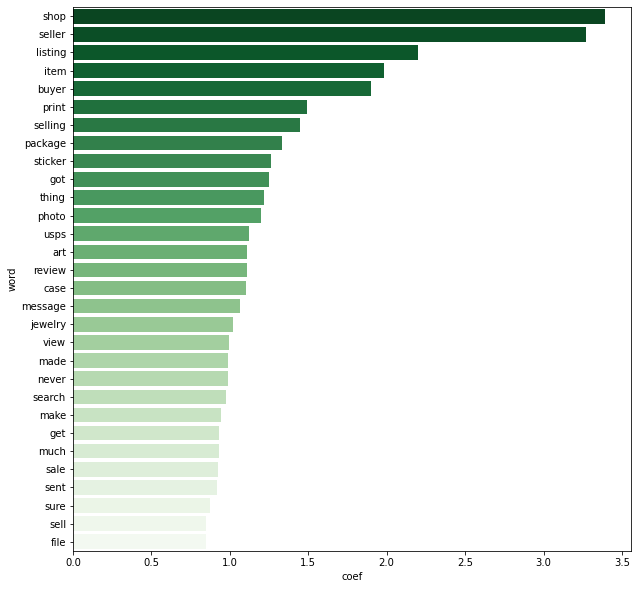

In [58]:
plt.figure(figsize=[10,10])
sns.barplot(data=etsy_word.head(30),y='word',x='coef',palette='Greens_r')

From the barplot of the word vs it's coefficient. We can see that there are 3 categories of words that plays a huge role in classifying Etsy posts. The first category of words the 'seller' (such as, shops, seller, USPS). The second is from the 'buyer' (such as, buyer, view, search) and the last categories are art and craft related (such as, sticker, art, jewelry). This insights are interesting but yet unsurprising, given that Etsy is a online marketplace which focused on handmade, or vintage items and craft supplies.

In [59]:
from wordcloud import WordCloud, STOPWORDS

In [60]:
from PIL import Image

In [61]:
mask_etsy = np.array(Image.open('./image/etsy_logo.png'))

In [62]:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(20, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

In [63]:
wordcloud_etsy = WordCloud(width = 3000,
                      height = 2000, random_state=42,
                      background_color='white',
                      colormap='Set2',
                      collocations=False,
                      stopwords = STOPWORDS,
                      mask=mask_etsy).generate(" ".join(etsy_word['word']))

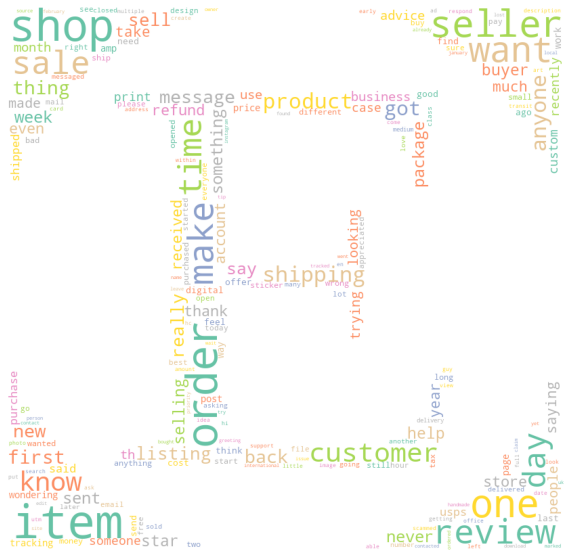

In [64]:
plot_cloud(wordcloud_etsy)

## Shopify Impactful Word(s) 

Next, we will be exploring what are the words that have the most impact in classifying Shopify subreddit post

In [65]:
shopify_word=tv_lr[tv_lr['coef']<0]

In [66]:
shopify_word['coef']=shopify_word['coef'].map(abs)

<ipython-input-66-d3bd176189f4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shopify_word['coef']=shopify_word['coef'].map(abs)


In [67]:
shopify_word.sort_values(by='coef',ascending=False,inplace=True)

<ipython-input-67-a9f4adee2411>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shopify_word.sort_values(by='coef',ascending=False,inplace=True)


In [68]:
shopify_word

,word,coef
4137,store,3.985025
252,app,2.689540
4356,theme,2.470990
3273,product,2.292470
2945,page,1.852026
...,...,...
3860,shipping address,0.000373
1831,hear back,0.000345
4597,updating,0.000173
3561,require,0.000161


<AxesSubplot:xlabel='coef', ylabel='word'>

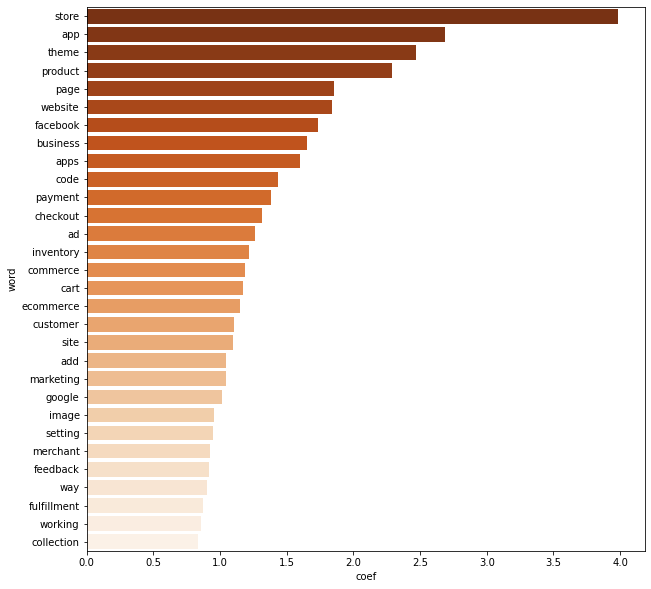

In [69]:
plt.figure(figsize=[10,10])
sns.barplot(data=shopify_word.head(30),y='word',x='coef',palette='Oranges_r')

From the barplot of the word vs it's coefficient. It's clear that majority of the post are from seller. A few of the focus are marketing platform from words such as 'facebook','google', 'website' to business needs such as, 'payment', 'checkout', 'cart' and 'inventory'. Again, these are interesting yet unsuprising insights. Shopify is a webstore platform to help seller create their own website, hence majority of the post should come from the seller. 

In [70]:
mask = np.array(Image.open('./image/shopify_logo.jpg'))

In [71]:
wordcloud = WordCloud(width = 3000,
                      height = 2000, random_state=42,
                      background_color='white',
                      colormap='Set2',
                      collocations=False,
                      stopwords = STOPWORDS,
                      mask=mask).generate(" ".join(shopify_word['word']))

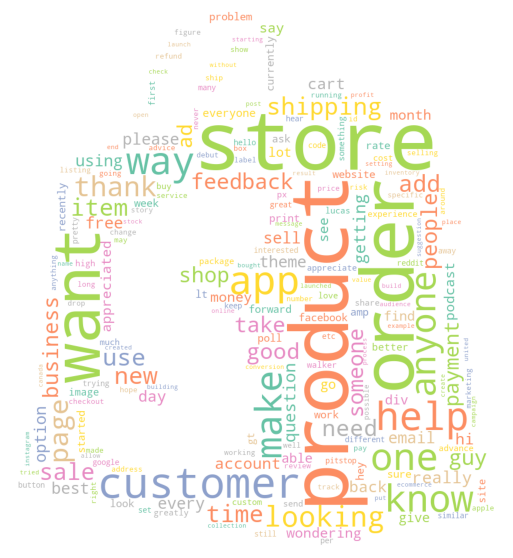

In [72]:
plot_cloud(wordcloud)

Next, we will explore on which posts was misclassified and also some correctly classified posts

## Evaluation of model

In [73]:
prediction = model_tv_lr.predict(X_test_clean)

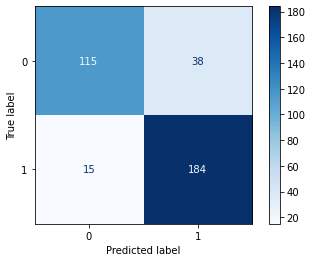

In [74]:
plot_confusion_matrix(model_tv_lr,
                      X=X_test_clean,
                      y_true=y_test,
                      cmap='Blues'
                     )

From the confusion matrix. It show that there are higher number of false positive label than the false negative. This could be due to the fact that Etsy is an online market place which will have both post from seller and buyer which increase the variablility of posts. However, since most of the post from Shopify come from seller, it has lesser variation.

In [75]:
predict=pd.DataFrame(zip(prediction,y_test),index=y_test.index,columns=['prediction','true'])

### Model 'Etsy' Prediction

In [76]:
true_etsy=X_test[(predict['prediction']==1)&(predict['true']==1)]

In [77]:
true_etsy.iloc[4,0]

"Hey guys, so i have an etsy store and i'm located in texas. Etsy collects and remits taxes on my behalf. I did notice that etsy collects taxes from ALLLL states that i ship to but doesnt collect tax on international orders. Now im just about to open shopify store and it telling me that I only need to collect tax on sales made to Texas since i dont have a nexus in other states.\n\nMy question is why does etsy collects tax on all states where as shopify only is doing it on texas sales? sooooo confusedTaxes"

Interestingly, one of the post in Etsy, despite having Shopify mention several times. Our model managed to classify them correctly as post from Etsy. 

In [78]:
false_etsy = X_test[(predict['prediction']==1)&(predict['true']==0)]

In [79]:
false_etsy.iloc[4,0]

'Hi all,\n\nI am starting a sticker shop on shopify. I read the shopify shipping guidelines. I understand that first class envelope is not cover due to certain dimension and weight. I am based in the US.\n\nShould I just use stamps for US and Canada? What are the best rate for Canada?\n\nEventually I would ship internationally, I would like to know if its best if I get [stamp.com](https://stamp.com) or pitney bowes account?  Any other apps for shopify for shipping that would cover letter size envelopes?\n\nAny recommendations?\n\n&amp;#x200B;\n\nPlease and Thank you!\n\nEmiQuestion about shipping : Starting a sticker shop'

From the above [barplot plot](#Etsy-Impactful-Word(s)), we can understand why this post was misclassified as Etsy given that 'sticker' has a high impact on the probability of classifying as Etsy. 

### Model 'Shopify' Predicition

In [80]:
true_shopify=X_test[(predict['prediction']==0)&(predict['true']==0)]

In [81]:
true_shopify.iloc[4,0]

'Don’t know if my title makes sense... So, I want the customer to go directly to a certain section in my policy when they click on the linked words without needing to scroll and look for it. I know I can connect the page, which I already have done but is there a way to link it directly to the paragraph so they don’t need to scroll through it all?Is there a way to insert a link to a sentence that goes to a specific line on another page so scrolling is not necessary?'

Some of the common correct classification of Shopify post have a few similarity. Most of the post belong to seller that are trying to discuss marketing approach as well as some enquiries about designing their websites

In [82]:
false_shopify = X_test[(predict['prediction']==0)&(predict['true']==1)]

In [83]:
false_shopify.iloc[5,0]

'Hello! Just want to know the best subreddits, social media to sell my products. Right now I have a digital download business for bridal shower games and wanting to expand to more. Facebook market place will not accept my products 😑 having a hard time getting anywhere on instagram as well.Where to advertise and sell?!'

Interestingly, the misclassified post tend to be seller from Etsy looking for ways to advertise and sell their products. We will further discuss this in the conclusion

## Conclusion and Recommendation

From our model, it shows that the post for Etsy are from both the seller and buyer while post for Shopify are mainly by the seller. Additionally, as Etsy is a creative marketplace which focus on handmade, vintage and craft supplies, there were indication of this focus by some of the key words having relation with art and craft. 

There are a few recommendation that we proposed to distinguish Etsy from our competitor and certain area of focus for us to effectively channel our marketing strategies.

First recommendation is to focus on promotion of our client product. From the misclassified post which were under Etsy but predicted to be Shopify, it can be seen that most of these post are focus on promoting their own product in different platform. However, as Etsy has our own platform where we have a huge built in audience, it would be an effective platform to enable publicity and attracting traffic flow to our client stores. 

Another area of focus could be to provide an effective channel for buyer to source for seller which can customize products that they are looking for. Given that Etsy effectiveness in supporting and promoting extraordinary items, from unique handcrafted piece to vintage treasure. It would be helpfully to allow seller to have a listing of crafting service which would give buyers the opportunity to find and get these personalize items.

By targeting these area of needs, stakeholder will be able to improve the user experience of both the seller and buyer and thus increasing the number of users for Etsy.